In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [ ]:
class NeuralNet:
    def __init__(self, dataFile):
        self.wine = pd.read_csv(dataFile, sep = ';')

    def exploratory_data_analysis(self):
      #Checking for missing values
      null_val = self.wine.isnull().sum()
      print("missing values in each variable \n \n" ,null_val, "\n")

      #Correlation analysis
      fig , ax = plt.subplots(figsize = (10,7))
      sns.heatmap(self.wine.corr() , annot = True , ax = ax)
      plt.show()

      #Variable selection
      X = self.wine.drop(['quality'], axis = 1)
      y = self.wine['quality']
      sc = StandardScaler()
      scaler = sc.fit(X)
      X = scaler.transform(X)

      model = RandomForestRegressor(random_state=1, max_depth=12)
      model.fit(X, y)
      wd = pd.get_dummies(self.wine)
      features = wd.columns
      importances = model.feature_importances_
      indices = np.argsort(importances)[:]
      plt.title('Feature Importances')
      plt.barh(range(len(indices)), importances[indices], color='r', align='center')
      plt.yticks(range(len(indices)), [features[i] for i in indices])
      plt.xlabel('Relative Importance')
      plt.show()
      return 0

    def preprocess(self):
      X = self.wine.drop(['quality'], axis = 1)
      le = LabelEncoder()
      y = le.fit_transform(self.wine.iloc[: , -1])
      y = pd.DataFrame(y.reshape(len(y),1))

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

      #To categorical
      self.y = tf.keras.utils.to_categorical(y, 8)
      self.y_train_cat = tf.keras.utils.to_categorical(y_train, 8)
      self.y_test_cat = tf.keras.utils.to_categorical(y_test, 8)

      #Standerdizing
      sc = StandardScaler()
      self.X = sc.fit_transform(X)
      self.X_train = sc.fit_transform(X_train)
      self.X_test = sc.fit_transform(X_test)
      return 0

    #Finding best hyperparameters.
    def param_Tuning(self):
      def create_model():
        model = Sequential()
        model.add(Dense(16, input_shape=(11,), activation='sigmoid'))
        model.add(Dense(8, activation='sigmoid'))
        model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.1), metrics=['accuracy'])
        return model
      model = KerasClassifier(model=create_model, verbose=0)
      learn_rate = [0.01, 0.1, 0.7]
      batch_size = [40, 60, 80]
      epochs = [10, 50, 100]
      param_grid = dict(optimizer__learning_rate=learn_rate, batch_size=batch_size, epochs=epochs)
      grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
      grid_result = grid.fit(self.X, self.y)

      self.l_rate = grid_result.best_params_['optimizer__learning_rate']
      self.max_it = grid_result.best_params_['epochs']
      print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
      means = grid_result.cv_results_['mean_test_score']
      stds = grid_result.cv_results_['std_test_score']
      params = grid_result.cv_results_['params']
      for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
      return 0

    #Fitting best model
    def evaluate_NN(self):
      def train_NN(h_layers):
        if h_layers == 2:
          NN_model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='sigmoid'),
            tf.keras.layers.Dense(8, activation='sigmoid'),
          ])
        if h_layers == 3:
          NN_model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='sigmoid'),
            tf.keras.layers.Dense(8, activation='sigmoid'),
            tf.keras.layers.Dense(8, activation= 'sigmoid')
          ])

        NN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=self.l_rate),
          loss = 'categorical_crossentropy' ,
          metrics= ['accuracy'])
        model_out = NN_model.fit(self.X_train,self.y_train_cat, epochs=self.max_it, validation_data=(self.X_test, self.y_test_cat), verbose=0)
        train_loss, train_acc = NN_model.evaluate(self.X_train, self.y_train_cat, verbose=0)
        test_loss, test_acc = NN_model.evaluate(self.X_test, self.y_test_cat, verbose=0)
        history_list = [model_out.history['accuracy'],model_out.history['val_accuracy'],train_acc, train_loss, test_acc, test_loss]
        return history_list

      #Train model for differnt hidden layers
      mod1 = train_NN(2)
      mod2 = train_NN(3)

      #Ploting Accuracy vs epochs for each model
      fig, axs = plt.subplots(1, 2, figsize=(10, 5))
      plt.subplots_adjust(wspace=0.8,)
      fig.suptitle('Accuracy')

      axs[0].plot(np.arange(1, (self.max_it+1)), mod1[0], label='2 hidden layers',lw=1)
      axs[0].plot(np.arange(1,(self.max_it+1)), mod2[0], label='3 hidden layers',lw=1)
      axs[0].set_title('Training Accuracy vs epoch', size=8)
      axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

      axs[1].plot(np.arange(1, (self.max_it+1)), mod1[1], label='2 hidden layers',lw=1)
      axs[1].plot(np.arange(1,(self.max_it+1)), mod2[1], label='3 hidden layers',lw=1)
      axs[1].set_title('Test Accuracy vs epoch', size=8)
      axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
      return 0

missing values in each variable 
 
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 



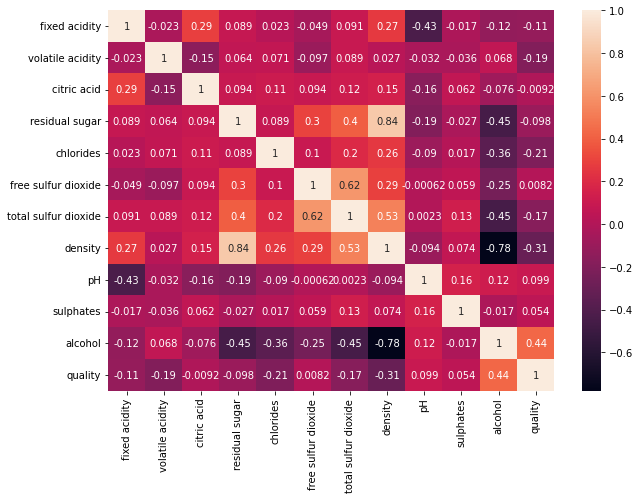

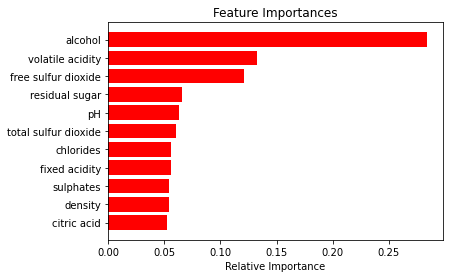

Best: 0.511032 using {'batch_size': 60, 'epochs': 10, 'optimizer__learning_rate': 0.1}
0.503679 (0.025498) with: {'batch_size': 40, 'epochs': 10, 'optimizer__learning_rate': 0.01}
0.500613 (0.026264) with: {'batch_size': 40, 'epochs': 10, 'optimizer__learning_rate': 0.1}
0.477131 (0.017723) with: {'batch_size': 40, 'epochs': 10, 'optimizer__learning_rate': 0.7}
0.486528 (0.016400) with: {'batch_size': 40, 'epochs': 50, 'optimizer__learning_rate': 0.01}
0.483055 (0.022057) with: {'batch_size': 40, 'epochs': 50, 'optimizer__learning_rate': 0.1}
0.486323 (0.020576) with: {'batch_size': 40, 'epochs': 50, 'optimizer__learning_rate': 0.7}
0.471833 (0.028398) with: {'batch_size': 40, 'epochs': 100, 'optimizer__learning_rate': 0.01}
0.478559 (0.016280) with: {'batch_size': 40, 'epochs': 100, 'optimizer__learning_rate': 0.1}
0.479785 (0.023187) with: {'batch_size': 40, 'epochs': 100, 'optimizer__learning_rate': 0.7}
0.467947 (0.014264) with: {'batch_size': 60, 'epochs': 10, 'optimizer__learning

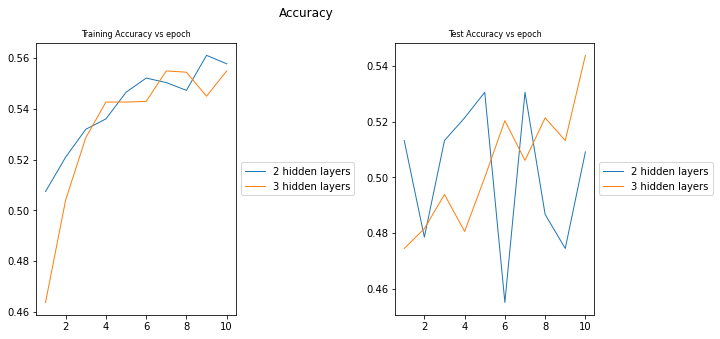

In [ ]:
url='https://drive.google.com/file/d/1c0ewOX_UzyZccFLJNV-GrHu8ZHFkHs15/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id

if __name__ == "__main__":
    neural_network = NeuralNet(dwn_url) # put in path to your file
    neural_network.exploratory_data_analysis()
    neural_network.preprocess()
    neural_network.param_Tuning()
    neural_network.evaluate_NN()